#### Sociology 128D: Mining Culture Through Text Data: Introduction to Social Data Science

# Notebook 8: Modeling Ratings and Sentiment using Python

In this notebook, we are going to explore a range of tools for statistical analysis in Python. To do this, we are going to use the text of Yelp reviews as well as various metadata. We will conclude with regression tables that can be displayed in the notebook, copied to a word processor, or rendered in HTML or LaTeX. In the optional exercises, you will adapt the code provided in the notebook to answer your own research question.

## Setup

You will likely need to install `contractions`,  `num2words`, `pingouin`, `stargazer`, `statsmodels`, `unidecode`, and `vaderSentiment`. You can install most of these using `conda` (if using Anaconda), but you will need to install `contractions` and `stargazer` using `pip` (see below).

`conda install -c conda-forge pingouin num2words statsmodels unidecode vadersentiment`


`pip install contractions` <br>
`pip install stargazer`


In [95]:
import contractions
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pingouin
import re
import seaborn as sns
import spacy
import statsmodels.formula.api as smf

from collections import defaultdict, Counter
from num2words import num2words
from pingouin import cronbach_alpha
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stopwords
from stargazer.stargazer import Stargazer
from statsmodels.stats.weightstats import ttest_ind
from unidecode import unidecode
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
np.random.seed(2423)

## I. Data

For this notebook, we are going to use the Yelp Open Dataset, which you can find [here](https://www.yelp.com/dataset). You'll have to click 'Download Dataset', agree to the terms, and click 'Download JSON'. It's a large download: ~5GB compressed and ~11GB once you've uncompressed it. The dataset has 8,635,403 reviews of businesses including text, a rating out of five stars, and various other information. The main file, <tt>yelp_academic_dataset_review.json</tt>, is quite large, and we are going to take a random sample of it.

In [3]:
os.listdir("data/yelp_dataset/")

['Dataset_User_Agreement.pdf',
 'yelp_academic_dataset_business.json',
 'yelp_academic_dataset_checkin.json',
 'yelp_academic_dataset_review.json',
 'yelp_academic_dataset_tip.json',
 'yelp_academic_dataset_user.json']

First, let's confirm the number of reviews. We'll iterate through the file line by line, counting the lines by incrementing <tt>num_reviews</tt>. Then we'll use `np.random.choice` to identify the *indices* of random elements from an array of the same length. Then we'll loop back through the lines of the main file and keep the lines whose index is a match for our sample. This approach allows us to avoid loading the full dataset into memory.

In [4]:
%%time

num_reviews = 0

with open("data/yelp_dataset/yelp_academic_dataset_review.json", "r", encoding="utf-8") as reader:
    for line in reader:
        num_reviews += 1

CPU times: total: 9.5 s
Wall time: 9.66 s


In [5]:
num_reviews

6990280

Using `np.arange` with <tt>num_reviews</tt> gives us an array of the same length as <tt>num_reviews</tt> from 0 to <tt>num_reviews</tt>-1. This is more or less doing the same thing as the more familiar `range` function, but it returns a NumPy array. You can use either, but `np.arange` is a good tool to have if you start working with NumPy more.

`np.random.choice` will take a sample of the values from the array of size <tt>size</tt> without replacement.

In [6]:
sample_indices = np.random.choice(np.arange(num_reviews), size=10000, replace=False)
len(sample_indices)

10000

Now, we will loop through the lines of the main file using `enumerate` to count as we go. For the first line, <tt>i</tt> will be 0. For the last line, <tt>i</tt> will be 8635402. For each line, if the corresponding value of <tt>i</tt> is in <tt>sample_indices</tt>, we will append the line to the list we've called <tt>sample</tt>.

In [7]:
%%time

sample = []

with open("data/yelp_dataset/yelp_academic_dataset_review.json", "r", encoding="utf-8") as reader:
    for i, line in enumerate(reader):
        if i in sample_indices:
            sample.append(line.strip())

CPU times: total: 1min 28s
Wall time: 1min 28s


JSON is a bit like a dictionary. If we use `json.loads`, we can turn each line (a string) into a dictionary.

In [8]:
sample = [json.loads(s) for s in sample]

In [9]:
sample[0]

{'review_id': 'Bh1cIMh_mZArniNQoCwZaA',
 'user_id': '0MeivhX0kZCfV3zMtHtk9Q',
 'business_id': 'W4ZEKkva9HpAdZG88juwyQ',
 'stars': 4.0,
 'useful': 0,
 'funny': 0,
 'cool': 0,
 'text': 'Excellent food, good service, great location. \n\nMy wife had shrimp and grits, I had the barbecued shrimp -- both were outstanding. The appetizers were good. The bread pudding was a tad dry in the city that is supposed to be the mother lode of bread pudding. \n\nMr. B came close to snagging the fifth star but the service could have been more attentive and the place is freezing - - in July in New Orleans. Wear long sleeves or bring a jacket.',
 'date': '2009-08-03 23:14:57'}

In [10]:
sample[0]["stars"]

4.0

In [11]:
sample[0]["text"]

'Excellent food, good service, great location. \n\nMy wife had shrimp and grits, I had the barbecued shrimp -- both were outstanding. The appetizers were good. The bread pudding was a tad dry in the city that is supposed to be the mother lode of bread pudding. \n\nMr. B came close to snagging the fifth star but the service could have been more attentive and the place is freezing - - in July in New Orleans. Wear long sleeves or bring a jacket.'

<tt>sample</tt> is a list of 10,000 dictionaries, each corresponding to one review. However, each fo these dictionaries has the same keys. We can use `pd.Dataframe` directly on this list to create a dataframe, and it will use the keys of the dictionaries as the columns.

In [12]:
df = pd.DataFrame(sample)

In [13]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Bh1cIMh_mZArniNQoCwZaA,0MeivhX0kZCfV3zMtHtk9Q,W4ZEKkva9HpAdZG88juwyQ,4.0,0,0,0,"Excellent food, good service, great location. ...",2009-08-03 23:14:57
1,EyKE4PxF1DocfP2cCCD8qQ,v8aeoMqdrClqfZxNB4lWCA,SZU9c8V2GuREDN5KgyHFJw,3.0,1,0,0,For a seafood restaurant at the edge of pear e...,2016-07-14 20:15:05
2,ljlip5S2hqb76p_pIlLPSg,vQs7uSrq04otWXLALYVcsQ,Zx7n8mdt8OzLRXVzolXNhQ,4.0,0,0,0,Beautiful atmosphere with locally sourced kitc...,2018-04-15 17:43:23
3,VvQBH-arNBcgROFyN6AVoA,kY6zjBIW5gGIUZLm2udfwg,ivRROeEdcTpH6U424-Pjew,5.0,0,0,0,Michael and Chris were great! It was easy to b...,2018-04-15 17:17:50
4,MdCSVa2EIivPbhrruYagQw,2bxIEpaa89Jss_TPOXttTQ,NJt2qvQ9NvB7uCxYUnW-dQ,4.0,0,0,0,I frequent the HOB in Oldsmar about once/month...,2012-05-29 02:48:02


In [14]:
df.date.min()

'2006-04-26 06:45:31'

In [15]:
df.date.max()

'2022-01-19 16:53:51'

Some quick preprocessing...

In [16]:
def fix_ordinal_nums(word: str) -> str:
    ord_num_reg = r"\d+[(st)(nd)(rd)(th)]"
    try:
        if any(re.findall(ord_num_reg, word)):
            word = re.sub("[(st)(nd)(rd)(th)]", "", word)
            word = num2words(word, lang="en", to="ordinal")
            
        return word
    
    except:
        
        return word


def preprocess_post(post: str) -> str:
    """
    Tokenize, lemmatize, remove stop words, 
    remove non-alphabetic characters.
    """
    post = unidecode(str(post))
    post = contractions.fix(post)
    post = [word.lemma_ for word in nlp(post) if (word.text not in spacy_stopwords) & (len(word.text) > 1)]
    post = " ".join([fix_ordinal_nums(word) for word in post])
    post = re.sub("[^a-z]", " ", post.lower())
    
    return re.sub("\s+", " ", post).strip()
    

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

In [17]:
%time df["preprocessed"] = df.text.apply(preprocess_post)

CPU times: total: 1min 32s
Wall time: 1min 32s


We aren't going to use the <tt>user_id</tt> column, and <tt>review_id</tt> is also an eyesore when we try to display the dataframe. Let's drop those columns and save our work.

In [18]:
df.drop(labels=["review_id", "user_id"], axis=1, inplace=True)
df.to_json("yelp_sample.json")

In [19]:
df = pd.read_json("yelp_sample.json")

In [20]:
df.head()

,business_id,stars,useful,funny,cool,text,date,preprocessed
0,W4ZEKkva9HpAdZG88juwyQ,4,0,0,0,"Excellent food, good service, great location. ...",2009-08-03 23:14:57,excellent food good service great location my ...
1,SZU9c8V2GuREDN5KgyHFJw,3,1,0,0,For a seafood restaurant at the edge of pear e...,2016-07-14 20:15:05,for seafood restaurant edge pear expectation s...
2,Zx7n8mdt8OzLRXVzolXNhQ,4,0,0,0,Beautiful atmosphere with locally sourced kitc...,2018-04-15 17:43:23,beautiful atmosphere locally source kitchen lo...
3,ivRROeEdcTpH6U424-Pjew,5,0,0,0,Michael and Chris were great! It was easy to b...,2018-04-15 17:17:50,michael chris great it easy book tour michael ...
4,NJt2qvQ9NvB7uCxYUnW-dQ,4,0,0,0,I frequent the HOB in Oldsmar about once/month...,2012-05-29 02:48:02,frequent hob oldsmar month drink eat caesar sa...


#### Business Metadata

Now we're going to fetch some info about the businesses themselves. First, we'll create a variable storing all of the unique business IDs in our sample. Next, we'll loop through the <tt>yelp_academic_dataset_business.json</tt> file and get info about the businesses whose IDs are in our sample.

The <tt>categories</tt> and <tt>attributes</tt> fields could be useful. They provide a lot of information about different properties of the businesses, from accessibility to ambience to type of business. <tt>categories</tt> is provided as a single string, so we're going to split that into individual categories. <tt>attributes</tt> has fewer total values, but the results are dictionaries. Some are True/False (e.g., 'Outdoor Seating') and some are more varied values (e.g., 'hours'). One of the attribute dictionaries, 'Ambience', has key/value pairs indicating whether a business is touristy, 'hipster', romantic, divey, intimate, trendy, upscale, classy, and/or casual (each True/False). We'll treat each of those as a separate attribute because we're going to use them in our analyses below. If you are interested in some of the other attributes, you may need to modify the code below to handle them how 'Ambience' is handled.

In [21]:
businesses_in_sample = df.business_id.unique()

In [22]:
len(businesses_in_sample)

8379

Let's take a look at the <tt>categories</tt> and <tt>attributes</tt> fields. The code below prints the results for the first review.

In [23]:
with open("data/yelp_dataset/yelp_academic_dataset_business.json", "r", encoding="utf-8") as reader:
    for line in reader:
        line = json.loads(line.strip())
        print(line["categories"])
        print()
        print(line["attributes"])
        break

Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists

{'ByAppointmentOnly': 'True'}


In [24]:
%%time

biz_categories_dict = defaultdict(lambda: {})
biz_attributes_dict = defaultdict(lambda: {})

with open("data/yelp_dataset/yelp_academic_dataset_business.json", "r", encoding="utf-8") as reader:
    for line in reader:
        line = json.loads(line.strip())
        biz_id = line["business_id"]
        if biz_id in businesses_in_sample:
            categories = line["categories"]
            attributes = line["attributes"]
            
            # check if "categories" is empty/None
            if categories:
                categories = categories.lower().split(",")
                categories = [cat.strip() for cat in categories]
                biz_categories_dict[biz_id] = set(categories)
            
            # check if "attributes" is empty/None
            if attributes:
                for key, value in attributes.items():
                    if key == "Ambience":
                        amb_categories = eval(value)
                        if type(amb_categories) == dict:
                            for cat, cat_val in amb_categories.items():
                                biz_attributes_dict[cat][biz_id] = cat_val
                    else:
                        biz_attributes_dict[key][biz_id] = value

CPU times: total: 30.3 s
Wall time: 30.3 s


Let's put all of the categories from <tt>categories</tt> together, count their frequencies (using `Counter`), and take a look at the most frequent.

In [25]:
all_categories = []
for cats in biz_categories_dict.values():
    all_categories += cats

In [26]:
len(set(all_categories))

935

In [27]:
c = Counter(all_categories)
c = sorted(list(c.items()), key=lambda x: x[1], reverse=True)

In [28]:
c[:200]

[('restaurants', 5277),
 ('food', 2124),
 ('nightlife', 1709),
 ('bars', 1614),
 ('american (traditional)', 1083),
 ('american (new)', 1014),
 ('breakfast & brunch', 845),
 ('sandwiches', 763),
 ('event planning & services', 731),
 ('shopping', 660),
 ('seafood', 568),
 ('pizza', 561),
 ('italian', 518),
 ('beauty & spas', 510),
 ('mexican', 506),
 ('coffee & tea', 492),
 ('burgers', 470),
 ('hotels & travel', 392),
 ('salad', 386),
 ('arts & entertainment', 383),
 ('home services', 355),
 ('cocktail bars', 346),
 ('desserts', 329),
 ('automotive', 319),
 ('cafes', 309),
 ('fast food', 297),
 ('specialty food', 293),
 ('local services', 288),
 ('active life', 288),
 ('health & medical', 275),
 ('sushi bars', 262),
 ('chinese', 259),
 ('beer', 258),
 ('wine & spirits', 258),
 ('japanese', 256),
 ('sports bars', 252),
 ('caterers', 251),
 ('bakeries', 251),
 ('pubs', 246),
 ('steakhouses', 245),
 ('venues & event spaces', 239),
 ('hotels', 224),
 ('wine bars', 224),
 ('asian fusion', 223

We can use <tt>biz_categories_dict</tt> and each review's <tt>business_id</tt> field to check whether each category was used to describe the business.

We can do the same for <tt>attributes</tt>.

In [29]:
for attribute in biz_attributes_dict.keys():
    print(attribute, len(biz_attributes_dict[attribute]))

NoiseLevel 4983
GoodForMeal 4361
RestaurantsGoodForGroups 5066
RestaurantsTableService 3168
WiFi 5836
GoodForKids 5479
Alcohol 5117
RestaurantsPriceRange2 6677
RestaurantsAttire 4769
BikeParking 6205
BusinessParking 6843
Caters 5015
RestaurantsReservations 5133
HasTV 5154
BusinessAcceptsCreditCards 7644
OutdoorSeating 5361
touristy 5118
hipster 5117
romantic 5118
divey 5062
intimate 5118
trendy 5118
upscale 5108
classy 5118
casual 5118
RestaurantsDelivery 5583
RestaurantsTakeOut 5742
HappyHour 2772
DogsAllowed 2945
BusinessAcceptsBitcoin 1623
WheelchairAccessible 2846
DriveThru 802
ByAppointmentOnly 2192
AcceptsInsurance 154
Music 1303
CoatCheck 1003
BestNights 1179
Corkage 718
BYOBCorkage 390
Smoking 823
BYOB 805
GoodForDancing 1000
HairSpecializesIn 49
RestaurantsCounterService 10
Open24Hours 8
AgesAllowed 18
DietaryRestrictions 7


Let's add a few variables (columns) to our dataframe reflecting different properties of the businesses. Note that with <tt>RestaurantsPriceRange2</tt>, we have to change the datatype from `str` to `float`.

In [30]:
df["RestaurantsPriceRange2"] = df.business_id.apply(lambda x: biz_attributes_dict["RestaurantsPriceRange2"].get(x, np.nan))
df.loc[df["RestaurantsPriceRange2"] == "None", "RestaurantsPriceRange2"] = np.nan
df = df.astype({"RestaurantsPriceRange2": "float"})

In [31]:
df.RestaurantsPriceRange2.unique()

array([ 3.,  2., nan,  1.,  4.])

In [32]:
df["BYOBCorkage"] = df.business_id.apply(lambda x: biz_attributes_dict["BYOBCorkage"].get(x, np.nan))
df.BYOBCorkage.unique()

array([nan, "'yes_free'", "'yes_corkage'", "'no'", "u'yes_corkage'",
       "u'no'", "u'yes_free'"], dtype=object)

In [33]:
d = {"'no'": 0, "'yes_free'": 1, "'yes_corkage'": 1, 'None': np.nan, "u'no'": 0}
df.BYOBCorkage = df.BYOBCorkage.apply(lambda x: d.get(x, np.nan))

In [34]:
Counter(df.BYOBCorkage.dropna())

Counter({1.0: 298, 0.0: 324})

In [35]:
# From 'Ambience' in the raw data
df["classy"] = df.business_id.apply(lambda x: biz_attributes_dict["classy"].get(x, np.nan))

In [36]:
df.head()

,business_id,stars,useful,funny,cool,text,date,preprocessed,RestaurantsPriceRange2,BYOBCorkage,classy
0,W4ZEKkva9HpAdZG88juwyQ,4,0,0,0,"Excellent food, good service, great location. ...",2009-08-03 23:14:57,excellent food good service great location my ...,3.0,NaN,True
1,SZU9c8V2GuREDN5KgyHFJw,3,1,0,0,For a seafood restaurant at the edge of pear e...,2016-07-14 20:15:05,for seafood restaurant edge pear expectation s...,2.0,NaN,True
2,Zx7n8mdt8OzLRXVzolXNhQ,4,0,0,0,Beautiful atmosphere with locally sourced kitc...,2018-04-15 17:43:23,beautiful atmosphere locally source kitchen lo...,2.0,NaN,True
3,ivRROeEdcTpH6U424-Pjew,5,0,0,0,Michael and Chris were great! It was easy to b...,2018-04-15 17:17:50,michael chris great it easy book tour michael ...,NaN,NaN,NaN
4,NJt2qvQ9NvB7uCxYUnW-dQ,4,0,0,0,I frequent the HOB in Oldsmar about once/month...,2012-05-29 02:48:02,frequent hob oldsmar month drink eat caesar sa...,1.0,NaN,False


In [37]:
df = df[df.business_id.isin(biz_categories_dict)]

In [38]:
df.shape

(9999, 11)

In [39]:
df["karaoke"] = df.business_id.apply(lambda x: "karaoke" in biz_categories_dict[x])
df["breweries"] = df.business_id.apply(lambda x: "breweries" in biz_categories_dict[x])
df["restaurant"] = df.business_id.apply(lambda x: "restaurant" in biz_categories_dict[x])
df["coffee"] = df.business_id.apply(lambda x: "coffee" in biz_categories_dict[x])
df["breakfast"] = df.business_id.apply(lambda x: "breakfast & brunch" in biz_categories_dict[x])

## II. Sentiment with VADER

To expand our toolkit a bit more in general and increase the range of variables we can explore in this notebook in particular, we are going to use VADER to analyze sentiment. You can check out the original paper here: [VADER: A Parsimonious Rule-based Model for  Sentiment Analysis of Social Media Text](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf). You can read more about it on the GitHub page [here](https://github.com/cjhutto/vaderSentiment).

VADER provides positive, neutral, and negative sentiment scores as well as a 'compound' score. According to the [GitHub page](https://github.com/cjhutto/vaderSentiment):
> The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

We'll focus on the compound score in our analyses. Let's print a couple of example reviews, the scores from VADER, and the number of stars the reviewer assigned.

In [40]:
analyzer = SentimentIntensityAnalyzer()

In [41]:
for idx, row in df.sample(2).iterrows():
    print(f"Review {idx}\n--")
    print(row.text)
    vs = analyzer.polarity_scores(row.text)
    print(vs)
    print(f"Stars: {row.stars}")
    print()

Review 9735
--
We came here for NYE & it was a prix fix menu and it was absolutely incredible. Each dish was 10/10 delicious, my boyfriend and I split everything and agreed that there wasn't one thing we liked more than another because it was all so good! 

What we had: 
-oysters and angel hair pasta: it was perfectly cooked and seasoned and was a great dish 
-Mississippi style bbq pork belly: this dish was incredible, the meat was so tender and the flavor was great. My boyfriend said this was the best dish he's ever eaten 
-gumbo: the presentation of the gumbo was unique and it was really good
-fish of the day: it was a mahi mahi and it was perfectly cooked and came with fresh veggies and gnocchi. I loved the gnocchi! 
-6 oz filet: the filet was delicious and came with potato's and crawfish. It was cooked to perfection 
-chocolate lava cake: was so rich and delicious and warm 
-bread pudding: delicious and beautiful. My boyfriend loved it

Overall, incredible restaurant. The service w

...and let's go ahead and compute the scores for each review in our sample.

In [42]:
%time df[["neg", "neu", "pos", "compound"]] = df.preprocessed.apply(lambda x: pd.Series(analyzer.polarity_scores(x)))

CPU times: total: 9.97 s
Wall time: 10 s


We'll also a variable for the day of the week that could be useful for focusing on reviews of particular types of events (e.g., dinner on Friday vs. Sunday brunch).

In [43]:
df["date"] = pd.to_datetime(df["date"])
df["day_name"] = df["date"].dt.day_name()

In [44]:
df.head()

,business_id,stars,useful,funny,cool,text,date,preprocessed,RestaurantsPriceRange2,BYOBCorkage,...,karaoke,breweries,restaurant,coffee,breakfast,neg,neu,pos,compound,day_name
0,W4ZEKkva9HpAdZG88juwyQ,4,0,0,0,"Excellent food, good service, great location. ...",2009-08-03 23:14:57,excellent food good service great location my ...,3.0,NaN,...,False,False,False,False,True,0.000,0.675,0.325,0.9571,Monday
1,SZU9c8V2GuREDN5KgyHFJw,3,1,0,0,For a seafood restaurant at the edge of pear e...,2016-07-14 20:15:05,for seafood restaurant edge pear expectation s...,2.0,NaN,...,False,False,False,False,False,0.089,0.705,0.206,0.8877,Thursday
2,Zx7n8mdt8OzLRXVzolXNhQ,4,0,0,0,Beautiful atmosphere with locally sourced kitc...,2018-04-15 17:43:23,beautiful atmosphere locally source kitchen lo...,2.0,NaN,...,False,False,False,False,True,0.000,0.630,0.370,0.9607,Sunday
3,ivRROeEdcTpH6U424-Pjew,5,0,0,0,Michael and Chris were great! It was easy to b...,2018-04-15 17:17:50,michael chris great it easy book tour michael ...,NaN,NaN,...,False,False,False,False,False,0.000,0.755,0.245,0.8555,Sunday
4,NJt2qvQ9NvB7uCxYUnW-dQ,4,0,0,0,I frequent the HOB in Oldsmar about once/month...,2012-05-29 02:48:02,frequent hob oldsmar month drink eat caesar sa...,1.0,NaN,...,False,False,False,False,False,0.000,0.706,0.294,0.9657,Tuesday


In [45]:
df.to_json("yelp_sample.json")

## III. Descriptive Statistics

Pandas dataframes have a `describe` method that provides basic [descriptive statistics](https://en.wikipedia.org/wiki/Descriptive_statistics). You can also compute them directly (e.g., by calling `.mean()` or `.median()`) or by using a library like NumPy directly.

In [46]:
df[["stars", "neg", "neu", "pos", "compound"]].describe()

,stars,neg,neu,pos,compound
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,3.731673,0.070456,0.601555,0.327993,0.675643
std,1.491091,0.084570,0.132313,0.157500,0.511678
min,1.000000,0.000000,0.152000,0.000000,-0.994200
25%,3.000000,0.000000,0.516000,0.218000,0.690800
50%,4.000000,0.046000,0.606000,0.324000,0.914500
75%,5.000000,0.108000,0.691000,0.435500,0.967400
max,5.000000,0.730000,1.000000,0.838000,0.998900


In [48]:
print(f"Mean: {np.mean(df.stars):.2f}")
print(f"Mean: {np.median(df.stars):.2f}")
print(f"Min: {np.min(df.stars):.2f}")
print(f"Max: {np.max(df.stars):.2f}")
print(f"Standard deviation (using n): {np.std(df.stars):.5f}") # default: formula for population standard deviation
print(f"Standard deviation (using n-1): {np.std(df.stars, ddof=1):.5f}") # use n-1 for sample standard deviation

Mean: 3.73
Mean: 4.00
Min: 1.00
Max: 5.00
Standard deviation (using n): 1.49102
Standard deviation (using n-1): 1.49109


## IV. Inferential Statistics

Inferential statistics is all about using what we know about a sample—including variability in the data, which is a source of uncertainty—to make inferences about the population from which a sample was drawn.

[Benjamin et al. (2018)](https://www.nature.com/articles/s41562-017-0189-z?source=post_page---------------------------) describe the typical approach to inferential statistics:

> In testing a point null hypothesis H<sub>0</sub> against an alternative hypothesis H<sub>1</sub> based on data x<sub>obs</sub>, the P value is defined as the probability, calculated under the null hypothesis, that a test statistic is as extreme or more extreme than its observed value. The null hypothesis is typically rejected — and the finding is declared statistically significant — if the P value falls below the (current) [type I error](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors) threshold α = 0.05.

Put differently, a p-value is our attempt to quantify the likelihood that we would observe the data we actually observe (including the test statistic derived from the data) if the null hypothesis were true. A low p-value suggests the likelihood of observing the data should be low *if the null hypothesis is correct*. We typically use a threshold like 0.05 as the cutoff for declaring statistical significance. If the p-value is >= 0.05, we *retain* the null hypothesis; if the p-value is < 0.05, we *reject* the null hypothesis.

We also refer to the 95% confience level (1 - 0.05) when α = 0.05. This is the conventional threshold, but Benjamin et al. (2018) argue against this for various reasons. [Consider this XKCD comic](https://xkcd.com/882/), for example.

The null hypothesis (H<sub>0</sub>) and the alternative hypothesis (usually referred to as H<sub>1</sub> or H<sub>A</sub>) will depend on the specific test.

#### Correlation

Correlation refers to the strength and direction of the (potential) relationship between two variables. Usually, we assume this relationship is pretty much linear. A positive correlation coefficient indicates that when one variable increases, the other does, too. A negative correlation implies that as one variable increases, the other instead decreases.

Correlation is sometimes considered to be part of descriptive statistics because correlation coefficients *describe* the strength of a relationship between two variabies. However, when we calculate a correlation coefficient, we also typically performance a hypothesis test, which is part of inferential statistics.

If we calculate the correlation coefficient between two continuous variables, our null hypothesis is that the correlation is 0 (i.e., that the variables are uncorrelated). A significant correlation coefficient suggests the variables are correlated at some confidence level (determined by the p-value).

You can calculate correlation coefficients directly using the [`.corr()` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) with your dataframe. By default, this will produce a correlation matrix using Pearson's *r*. You can add the "spearman" argument for Spearman's rho or "kendall" for the Kendall rank correlation coefficient.

In [49]:
df[["stars", "neg", "neu", "pos", "compound", "RestaurantsPriceRange2"]].corr()

,stars,neg,neu,pos,compound,RestaurantsPriceRange2
stars,1.000000,-0.564180,-0.351418,0.598112,0.618601,0.026787
neg,-0.564180,1.000000,0.006584,-0.542440,-0.748831,-0.039850
neu,-0.351418,0.006584,1.000000,-0.843644,-0.304461,-0.021236
pos,0.598112,-0.542440,-0.843644,1.000000,0.657833,0.039151
compound,0.618601,-0.748831,-0.304461,0.657833,1.000000,0.066896
RestaurantsPriceRange2,0.026787,-0.039850,-0.021236,0.039151,0.066896,1.000000


In [50]:
df[["stars", "neg", "neu", "pos", "compound", "RestaurantsPriceRange2"]].corr("spearman")

,stars,neg,neu,pos,compound,RestaurantsPriceRange2
stars,1.000000,-0.497712,-0.359205,0.584221,0.471910,0.025430
neg,-0.497712,1.000000,0.102358,-0.562320,-0.470871,-0.024779
neu,-0.359205,0.102358,1.000000,-0.833949,-0.341587,-0.020790
pos,0.584221,-0.562320,-0.833949,1.000000,0.607715,0.044515
compound,0.471910,-0.470871,-0.341587,0.607715,1.000000,0.100387
RestaurantsPriceRange2,0.025430,-0.024779,-0.020790,0.044515,0.100387,1.000000


We can also save the whole correlation matrix as a variable (here, <tt>correlation_matrix</tt>) and plot it using Seaborn's `heatmap` function.

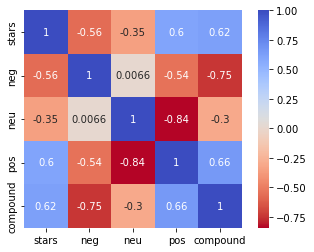

In [51]:
correlation_matrix = df[["stars", "neg", "neu", "pos", "compound"]].corr()
sns.heatmap(correlation_matrix, cmap="coolwarm_r", annot=True, square=True)
plt.show()

The `pingouin` library adds features like the [`rcorr` method](https://pingouin-stats.org/generated/pingouin.rcorr.html), which display correlation coefficients in the lower triangle and significance levels (represented by asterisks) in the upper triangle.

In [52]:
df[["stars", "compound", "RestaurantsPriceRange2"]].rcorr("spearman")

,stars,compound,RestaurantsPriceRange2
stars,-,***,*
compound,0.472,-,***
RestaurantsPriceRange2,0.025,0.1,-


`scipy.stats` makes it easy to access the correlation coefficient and p-value for specific pairs of variables.

In [53]:
pearsonr(df.stars, df.compound)

(0.6186008051993412, 0.0)

In [54]:
spearmanr(df.stars, df.compound)

SpearmanrResult(correlation=0.4719102400942906, pvalue=0.0)

We can access the individual pieces of information (the correlation coefficient *r* and the p-value) by assigning the results to two variables (<tt>r</tt> and <tt>pvalue</tt>) separated by a comma.

In [66]:
r, pvalue = pearsonr(df.stars, df.compound)

In [67]:
r

0.6186008051993412

**Note: The p-value is being rounded down to zero. It's not precisely zero. We will never be that certain if we are only looking at a sample.**

In [68]:
pvalue

0.0

#### Comparing group means with *t*-tests

To test for differences in the means between two groups, we'll use the `statsmodels` implementation of independent samples *t*-tests, `ttest_ind`. Specifically, we are going to test whether restaurants categorized as breweries and restaurants categorized as having karaoke have different ratings on average.

First, we want to make sure that our groups do not overlap (i.e., that no restaurant in our sample is a brewery that does karaoke). The code below checks whether there are any reviews for businesses that are describes as breweries and as having karaoke. There should be none in the sample.

Next we'll compare the mean star-rating for each of these groups and then conduct a *t*-test. `ttest_ind` returns the *t*-statistic, the *p*-value, and another piece of information we won't get into called the degrees of freedom. In this sample, there is not a significant difference in the mean star-rating of breweries and businesses offering karaoke.

In [58]:
df[(df.karaoke==True) & (df.breweries==True)].shape

(0, 21)

In [59]:
print(df[df.karaoke==True].stars.mean())
print(df[df.breweries==True].stars.mean())

3.8
4.053333333333334


On average, breweries get an extra 0.25 stars, but the p-value is greater than 0.05, so we *retain* (or *fail to reject*) the null hypothesis. In other words, we would conclude there is no evidence of a difference between these groups.

In [61]:
print(df[df.breweries==True].stars.mean()-df[df.karaoke==True].stars.mean())

0.25333333333333385


In [72]:
t, pvalue, _ = ttest_ind(df[df.karaoke==True].stars, df[df.breweries==True].stars, usevar="unequal")
print(f"t = {t:.2f}, p = {pvalue:.2f}")

t = -0.75, p = 0.47


How about restaurants that are described as classy or not?

In [69]:
print(df[df.classy==True].stars.mean())
print(df[df.classy==False].stars.mean())

3.94756711409396
3.6802405028696366


In [70]:
print(df[df.classy==True].stars.mean()-df[df.classy==False].stars.mean())

0.26732661122432333


In [71]:
t, pvalue, _ = ttest_ind(df[df.classy==True].stars, df[df.classy==False].stars, usevar="unequal")
print(f"t = {t:.2f}, p = {pvalue:.2f}")

t = 7.51, p = 0.00


On average, restaurants described as classy receive an extra 0.27 stars. The p-value has been rounded down to zero, and isn't actually zero; but we can conclude that the group means are significantly different at the p < 0.01 level (or 99% confidence level).

#### Linear Regression with OLS

Now we will turn to linear regression using ordinary least squares (OLS). OLS tests the strength and significance of the relationship between the dependent variable ('outcome' or 'response' variable) and each independent variable ('predictor' or 'explanatory variable') in a way that can seem more flexible and interpretable than the previous tests. Whereas correlation coefficients are 'unit-free', a regression coefficient is interpreted as the unit change in the y variable for a unit change in the x variable. The intercept (or 'constant') in the model is the conditional mean of the dependent variable.

We are going to use the [`statsmodels` library](https://www.statsmodels.org/stable/index.html) to train our regression models and the [`stargazer` library](https://github.com/mwburke/stargazer) to format regression tables. <tt>compound</tt> is a continuous variable ranging between -1 and 1. <tt>RestaurantsPriceRange2</tt> is an ordinal variable ranging from 1 to 4, though we can treat it as a continuous variable. <tt>breakfast</tt> and <tt>classy</tt> are stored as `bools` (True/False), and `statsmodels` will implicitly treat them as categorical variables where `False` == 0 and `True` == 1. This means that they will be treated as dummy variables (another name for binary or dichotomous variables), and the coefficient for each variable indicates the change in the outcome when the variable is `True` (or 1), as opposed to `False` (or 0).

More specifically, we are going to use `statsmodels.formula.api`, which allows us to write our regression equations using R-like syntax: e.g., `y ~ x1 + x2`. See [here](https://www.statsmodels.org/devel/example_formulas.html).

In [73]:
# We are going to create a subset of the dataframe without missing data for the variables in our models
tmp = df[["compound", "RestaurantsPriceRange2", "breakfast", "classy"]].dropna()

formula = "compound ~ RestaurantsPriceRange2 + breakfast"
ols1 = smf.ols(formula, data=tmp).fit()

formula = "compound ~ RestaurantsPriceRange2 + breakfast + classy"
ols2 = smf.ols(formula, data=tmp).fit()

In [74]:
reg_table = Stargazer([ols1, ols2])
reg_table

`stargazer` offers numerous methods for editing the appearance of the table, for example the order the independent variables appear in, the names of the independent variables, and the title of the table.

In [75]:
reg_table = Stargazer([ols1, ols2])
reg_table.covariate_order(["RestaurantsPriceRange2", "breakfast[T.True]", "classy[T.True]", "Intercept"])
reg_table.rename_covariates({"RestaurantsPriceRange2": "Price", "breakfast[T.True]": "Breakfast", "classy[T.True]": "Classy"})
reg_table.title("Compound Sentiment Regressed on Price, Ambience, and Breakfast")
reg_table.show_model_numbers(False)
reg_table.significance_levels([0.05, 0.01, 0.001])
reg_table.custom_columns(["Model 1", "Model 2"], [1, 1])

In [76]:
reg_table

**Interpretation:**
For each tier increase in the measure of the restaurant's price range, we would expect the <tt>compound</tt> sentiment score of a review to increase by 0.088 on average according to Model 1 or by 0.062 on average according to Model 2, net of the other variables in each model.

Serving breakfast is associated with an increase in the <tt>compound</tt> sentiment score of approximately 0.039 (Model 1) or 0.031 (Model 2), net of the other variables in each model.

Businesses characterized as having a "classy" ambience score 0.073 higher on the <tt>compound</tt> score of sentiment on average, net of price and whether or not the business serves breakfast.

Based on a comparison of the coefficients in these two models, it appears that controlling for whether a restaurant is categorized as <tt>classy</tt> accounts for some of the association between the outcome and the other independent variables. For example, the coefficient on price decreases from 0.088 to 0.062 when we control for <tt>classy</tt>. This could be interpreted in different ways.

For example, classiness may be associated both with higher prices and with factors that lead to more positive reviews (i.e., higher <tt>compound</tt> scores). This would be an example of confounding. Alternatively, it may be that higher prices make a restaurant seem more classy, which in turn leads to more positive reviews. This would be an example of partial mediation, and there are more formal ways to test for this. The larger point is that this is observational data and as much as we may like to offer causal interpretations, we can't be certain. Our job when using tools like linear regression is to come up with the best hypothesis we can, motivated by the best theory, and then use our models (and the results of significance tests) as components of an argument.

In OLS, each coefficient is being tested using the null hypothesis (H<sub>0</sub>) that the coefficient is equal to zero. A significant coefficient on any of the independent variables indicates we can reject the null hypothesis and conclude that the two variables are related in some way. The coefficient quantifies the strength of that relationship.

Note that both the R<sup>2</sup> and Adjusted R<sup>2</sup> increase from Model 1 to Model 2. The R<sup>2</sup> is a measure of how much variance in the outcome is explained by the independent (or explanatory) variables. This tends to increase if we add additional independent variables. The adjusted R<sup>2</sup> is penalized for each additional variable, so it is slightly lower the plain R<sup>2</sup> in Model 2.

A **crucial point** with this kind of statistical modeling is that we ultimately should not care much about the R<sup>2</sup> or Adjusted R<sup>2</sup>. If we are interested in the relationship between some variable x and another variable y, we want to include additional variables only if we expect that they confound the relationship (i.e., have an effect on both x and y) or, more generally, are a source of [omitted-variable bias](https://en.wikipedia.org/wiki/Omitted-variable_bias). If you want a deeper dive into these issues, see [this paper](https://journals.sagepub.com/doi/full/10.1177/0049124118782542), although it is a reply to a comment on another paper, so a lot of the original context won't be immediately clear.

With Stargazer, can also produce LaTeX code for the table directly:

In [77]:
print(reg_table.render_latex())

\begin{table}[!htbp] \centering
  \caption{Compound Sentiment Regressed on Price, Ambience, and Breakfast}
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable:}} \
\cr \cline{2-3}
\\[-1.8ex] & \multicolumn{1}{c}{Model 1} & \multicolumn{1}{c}{Model 2}  \\
\hline \\[-1.8ex]
 Price & 0.088$^{***}$ & 0.062$^{***}$ \\
  & (0.011) & (0.012) \\
 Breakfast & 0.039$^{*}$ & 0.031$^{*}$ \\
  & (0.016) & (0.016) \\
 Classy & & 0.073$^{***}$ \\
  & & (0.013) \\
 Intercept & 0.548$^{***}$ & 0.570$^{***}$ \\
  & (0.021) & (0.022) \\
\hline \\[-1.8ex]
 Observations & 5,947 & 5,947 \\
 $R^2$ & 0.012 & 0.017 \\
 Adjusted $R^2$ & 0.012 & 0.016 \\
 Residual Std. Error & 0.457(df = 5944) & 0.456(df = 5943)  \\
 F Statistic & 35.851$^{***}$ (df = 2.0; 5944.0) & 34.140$^{***}$ (df = 3.0; 5943.0) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{2}{r}{$^{*}$p$<$0.05; $^{**}$p$<$0.01; $^{***}$p$<$0.001} \\
\end{tabular}
\end{table}

#### Logistic Regression

Finally, we will take a quick look at an example of logistic regression using `statsmodels`. Coefficients are reported in log-odds, but interpretations are otherwise similar: A unit change in x is associated with a change in the log-odds of y of some amount.

For our dependent variable, we'll use the BYOBCorkage attribute, which we have dichotomized to no == 0 and yes == 1. What factors affect whether the restaurant will uncork your BYOB wine for you?

In [78]:
# We are going to create a subset of the dataframe without missing data for the variables in our models
tmp = df[["BYOBCorkage", "RestaurantsPriceRange2", "breakfast", "classy"]].dropna()

formula = "BYOBCorkage ~ RestaurantsPriceRange2 + breakfast"
logit1 = smf.logit(formula, data=tmp).fit()

formula = "BYOBCorkage ~ RestaurantsPriceRange2 + breakfast + classy"
logit2 = smf.logit(formula, data=tmp).fit()

logit_table = Stargazer([logit1, logit2])
logit_table.covariate_order(["RestaurantsPriceRange2", "breakfast[T.True]", "classy[T.True]", "Intercept"])
logit_table.rename_covariates({"RestaurantsPriceRange2": "Price", "breakfast[T.True]": "Breakfast", "classy[T.True]": "Classy"})
logit_table.title("BYOBCorkage Regressed on Price, Ambience, and Breakfast")
logit_table.show_model_numbers(False)
logit_table.significance_levels([0.05, 0.01, 0.001])
logit_table.custom_columns(["Model 1", "Model 2"], [1, 1])
logit_table

Optimization terminated successfully.
         Current function value: 0.682686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681985
         Iterations 4


**Interpretation:**
According to the first model, an increase in the price range of the business is associated with a 0.298 increase in the log-odds that the business will uncork your BYOB wine. When we control for whether the restaurant is considered classy (Model 2), we no longer observe a significant relationship between price and the outcome.

Note that the lines for R<sup>2</sup> and Adjusted R<sup>2</sup> are blank for the logistic regression table. We cannot calculate a true R<sup>2</sup> or Adjusted R<sup>2</sup> using logistic regression. There are alternatives that try to quantify how well the model fits the data, but they aren't implemented here.

## V. Supervised Machine Learning

Whereas inferential statistics is concerned with generalizing from a sample to a population by quantifying uncertainty, and we often want to know about the relationship between two specific variables net of any potential confounders, that's all (usually) beside the point in supervised machine learning. We want to train models that predict outcomes well, regardless of the substantive importance of the relationship in question. Confounding is no longer an issue–we just want to predict the outcome well and in a way that generalizes to unseen data.

One thing you may notice–and which may cause some confusion–is that tools we use for inferential statistics can be used for supervised machine learning and vice versa. The two biggest categories of machine learning are *regression* (predicting continuous outcomes, like income or ratings) and *classification* (predicting membership in a category). We used OLS for linear regression in the inferential statistics section, and we can use OLS for supervised machine learning as well. Further, we used logistic regression for inferential statistics, and we can use it for classification tasks in the context of supervised machine learning.

#### Regression

In regression tasks in a supervised machine learning framework, we want to minimize an objective function like the mean squared error or root mean squared error. [Mathematically, this is equivalent to *maximizing* the R<sup>2</sup>](https://stats.stackexchange.com/questions/250730/what-is-the-mathematical-relationship-between-r2-and-mse).

In [97]:
docs = df.preprocessed.tolist()
y = df.compound.tolist()

X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size=0.3, random_state=8675309)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

regr = LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

In [101]:
print(f"Coefficients: \n{regr.coef_}")
print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")

Coefficients: 
[ 0.04676098 -0.48820371  0.14318015 ...  0.54007375  0.00203847
 -0.18193904]
Mean squared error: 1.6000263767156804


#### Classification

In classification problems, two major properties of our models are *precision* and *recall*. The diagram below clarifies the difference between the two. In practice, people often default to using an [F-score](https://en.wikipedia.org/wiki/F-score), such as F<sub>1</sub>, which is the harmonic mean of precision and recall.

<img src="https://raw.githubusercontent.com/soc128d/soc128d.github.io/master/assets/images/precision_recall_wiki_walber_side_by_side.png" width=800 align="left"/> <br>

([Image source](https://en.wikipedia.org/wiki/F-score#/media/File:Precisionrecall.svg))

In [83]:
df.compound.describe()

count    9999.000000
mean        0.675643
std         0.511678
min        -0.994200
25%         0.690800
50%         0.914500
75%         0.967400
max         0.998900
Name: compound, dtype: float64

In [87]:
df["compound_binary"] = df.compound.apply(lambda x: x >= df.compound.median())

In [88]:
df.compound_binary.head()

0     True
1    False
2     True
3    False
4     True
Name: compound_binary, dtype: bool

In [93]:
%%time

docs = df.preprocessed.tolist()
labels = df.compound_binary.tolist()

X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size=0.3, random_state=8675309)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

clf = LogisticRegression(fit_intercept=False, solver="sag", penalty="l2", max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.79      0.66      0.72      1513
        True       0.70      0.82      0.76      1487

    accuracy                           0.74      3000
   macro avg       0.75      0.74      0.74      3000
weighted avg       0.75      0.74      0.74      3000

CPU times: total: 4.12 s
Wall time: 4.12 s


You can read more about [`classification_report` here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

## VI. Exercises

<div class="alert alert-warning">
    For the exercises in this notebook, you will use the <tt>categories</tt> and <tt>attributes</tt> data to create new variables to answer a social research question. You will then use t-tests or correlation coefficients and finally a linear or logistic regression to test your hypothesis. <br><br>
    <b>Exercise 1</b><br><br>
    Keeping in mind the variables you will create, what is your research question? You might find it helpful to pose your question in terms of the relationship between two variables. At least one of these should be a continuous variable (or a variable that can be treated as continuous). It may also be helpful to use one of the pre-existing continuous variables (e.g., star ratings or sentiment) as the outcome (dependent variable). Why did you choose these variables? Why might they be related? Are there variables that you may need to control for in order to model the relationship between your two variables? You might also consider using a subset of the data confined to a particular period of time. If needed, you can start with a sample larger than the 10,000-review sample taken at the start of the notebook. (You may also find it helpful to wait to fully finish this question until you've made sure you can create the variables you have in mind.)
</div>

*Your answer here*

<div class="alert alert-warning">
    <b>Exercise 2</b><br><br>
    2.1 Now create two variables. If you are using one of the pre-existing variables as your independent or (more likely) dependent variable, you might create the other variable and then create an additional variable to use as a control variable. The variables should fit your research question. <br><br>
    Remember, you can create variables using code like the following: </div>
    
```python
df["classy"] = df.business_id.apply(lambda x: biz_attributes_dict["classy"].get(x, np.nan))
```

```python
df["karaoke"] = df.business_id.apply(lambda x: "karaoke" in biz_categories_dict[x])
```

In [ ]:
# YOUR CODE HERE

<div class="alert alert-warning">
2.2 Be sure to check the values of your new variables and recode them if needed. You can using code like <tt>df.NEW_VARIABLE.unique()</tt> to display the unique values.
</div>

In [ ]:
# YOUR CODE HERE

<div class="alert alert-warning">
    <b>Exercise 3</b><br><br>
    3.1 If your independent and dependent variables are both continuous (or can be treated as continuous, e.g. <tt>RestaurantsPriceRange2</tt>), are they correlated with one another? Use <tt>pearsonr</tt> or <tt>spearmanr</tt> from <tt>scipy.stats</tt> and report both the correlation coefficient and p-value. If only one of these variables is continuous, then select two groups from your categorical variable (e.g., the True and False groups) to compare with respect to the continuous variable. What are the group means of the continuous variable? Is one mean substantially higher? Is there a significant difference according to a t-test? Use <tt>ttest_ind</tt>. Report the group means, the difference, the results of the t-test. What do the results say about your research question? Do they fit with your expectations?</div>

In [ ]:
# YOUR CODE HERE

*Your answer here*

<div class="alert alert-warning">
    3.2 Now, assuming your dependent variable is continuous, train at least two linear regression models using OLS (and <tt>smf.ols</tt>). If your dependent variable is categorical, then make sure you are using a binary version of it (i.e., only two groups) and train at least two logistic regression models using <tt>smf.logit</tt> instead. The models should be trained using the same observations and should only differ in that the second (or third, etc.) model has one additional control variable. The addition of a control variable may reflect what you write in Exercise 1. You can train the models on the same subset of observations by using code like the code below to exclude any observations missing data for any of the variables you will use:</div>
    
```python
tmp = df[["compound", "RestaurantsPriceRange2", "breakfast", "classy"]].dropna()
```

In [ ]:
# YOUR CODE HERE

<div class="alert alert-warning">
    3.2 Now use <tt>stargazer</tt> to make a regression table presenting the results of your models.
</div>

In [ ]:
# YOUR CODE HERE

<div class="alert alert-warning">
    3.3 Interpret the results. Do they fit your expectations? What do they tell us about your research question?
</div>

*Your answer here*